# IP Storage

We consider a storage for IP addresses. The storage supports `add` and `delete` operations. The storage is implemented as a binary tree with a root + 32 levels. Each node in the tree has a counter initially set to 0. Each non-leaf node has two outgoing edges despicted '0' and '1'. To add an IP we:
* convert the IP to a 32-bit binary form
* We traverse the tree from the root to the leaf following the edges as indicated by the IP binary form. For instance an IP starting with `101...` will first go to root, then go to level 1 via edge `1`, then go to level 2 via edge `0`, then go to level 3 via edge `1` and so on
* We increment the counter by 1 at each traversed node. 

Note that the root counter holds the total number of IPs in the tree. 

The `delete` method operates in the same way, but decreases the counter rather than increasing them. 

## IP Score
Adding an IP address via `add` returns a similarity score (from 0 to 1). It provides of similarity measure between the IP being added and IP addresses already in the storage. Intuitively, high similarity scores (close to 1) means that the IP being added is very similar to IP addresses already in the table. Low scores (close to 0) indicates that the IP being added is very different from IPs already in the table. 

Before a new IP is added, we calculate a `balanced_counter` for each level of the tree expressed as `balanced_counter(level) = rootCounter / (2^level)`. For instance, if there are 8 IPs in the storage, `balanced_counter(0) = 8 / (2^0) = 8`, `balanced_counter(1) = 8 / (2^1) = 4`, `balanced_counter(2) = 8 / (2^2) = 4` etc. 

When adding a IP, we create a new variable `score(IP) = 0`. At each encounterd node, we compare the node counter with the `balanced_counter` at the respective level. This is done before incrementing the counter. If the counter is higher than the `balance_counter` we increase the `score(IP)` by 1. An IP can get up to 32 points if such the IPs are already present in the storage. We then normalize the score by dividing it by 32 and return it a the similarity score. 


Below, we create helper function to generate diverse IP and should get very low similarity score when added to the storage. 

In [51]:
#!/usr/bin/python3 
import matplotlib.pyplot as plt

# helper function to flip a bit written as a string/character
def flip(b):
    assert(b == '0' or b == '1')
    if (b == '0'):
        return '1'
    return '0'

# generates a specified amount of IPs that will get the lowest possible score in the IP tree
def generate_IPs(n):
    ips = []
    init_ip = list('1'*32)
    for i in range(0, n):
        for j in range(0, len(init_ip)):
            if((i % (2**j)) == 0):
                init_ip[j] = flip(init_ip[j])
        
        ip_str = ''
        for octet in range(0, 4):
            offset = octet*8
            octet_str = str(int(''.join(init_ip[offset:offset + 8]), 2))
            ip_str  = ip_str + '.' + octet_str
        #remove the first '.'
        ips.append(ip_str[1:])
    return ips


When we add uniquely diverse IPs, the score is always 0 (as it should be):

avg good score 0.0


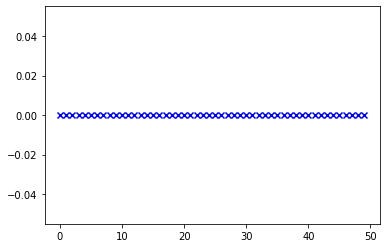

In [52]:
from TreeMichal import *

ips = generate_IPs(50)
tree = TreeMichal()
#plotting
fig = plt.figure()
ax = fig.add_subplot()

counter = 0
good_scores = []

for ip in ips:
    score,_ = tree.add(ip)
    good_scores.append(score)
    ax.scatter(counter, score, label='score2, benign', color='blue', marker='x')
    
    counter += 1
print("avg good score", sum(good_scores)/len(good_scores))
plt.show()

We consider two populations of requests. Malicious and benign. The benign one will add uniquely different IPs. The malicious ones, will make the same amount of requests but will try to add a number of IPs lower than the number of requests.

This is what happens when "malicious" requests use only 1 IP address. They get almost uniquely 1 as a similarity score, but it also increases the score for some of the honest requests.

avg good score 0.04625
avg bad score 0.980625


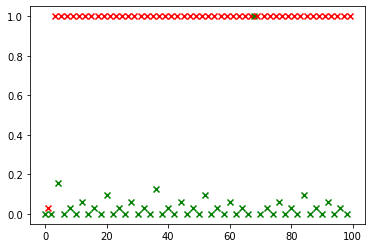

In [53]:
import random
from TreeMichal import *

ips = generate_IPs(50)
malicious_ips_num = 1
malicious_ips = set()
while(len(malicious_ips) < malicious_ips_num):
    malicious_ips.add(ips[random.randint(0, len(ips)-1)])
    malicious_ips = list(malicious_ips)

#plotting
fig = plt.figure()
ax = fig.add_subplot()

tree = TreeMichal()
counter = 0
good_scores = []
bad_scores = []

for ip in ips:
    score,_ = tree.add(ip)
    good_scores.append(score)
    ax.scatter(2*counter, score, label='benign', color='green', marker='x')
    
    score,_ = tree.add(malicious_ips[counter % len(malicious_ips)])
    bad_scores.append(score)
    ax.scatter(2*counter + 1, score, label='malicious', color='red', marker='x')
    counter += 1
print("avg good score", sum(good_scores)/len(good_scores))
print("avg bad score", sum(bad_scores)/len(bad_scores))
plt.show()

Increasing the number of different IPs used by the malicious requests makes the two score more similar. 

avg good score 0.18625
avg bad score 0.818125


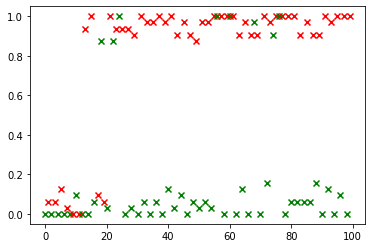

In [54]:
import random
from TreeMichal import *

ips = generate_IPs(50)
malicious_ips_num = 10
malicious_ips = set()
while(len(malicious_ips) < malicious_ips_num):
    malicious_ips.add(ips[random.randint(0, len(ips)-1)])
malicious_ips = list(malicious_ips)

#plotting
fig = plt.figure()
ax = fig.add_subplot()

tree = TreeMichal()
counter = 0
good_scores = []
bad_scores = []

for ip in ips:
    score,_ = tree.add(ip)
    good_scores.append(score)
    ax.scatter(2*counter, score, label='benign', color='green', marker='x')
    
    score,_ = tree.add(malicious_ips[counter % len(malicious_ips)])
    bad_scores.append(score)
    ax.scatter(2*counter + 1, score, label='malicious', color='red', marker='x')
    counter += 1
print("avg good score", sum(good_scores)/len(good_scores))
print("avg bad score", sum(bad_scores)/len(bad_scores))
plt.show()

This is an average score received by benign and malicious population based on the number of distinct malicious IPs. Note that it does not depend on the number of IPs. Only on the IP ratio used by benign and malicious requests.

There are 500 ips and 500 distinct ips.


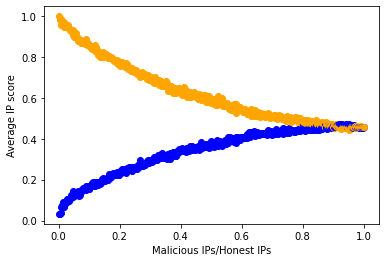

In [55]:
#!/usr/bin/python3 

import math
import matplotlib.pyplot as plt
import random

from TreeMichal import *

def compare_average_score(ip_num, ax, benign_color, malicious_color):
    ips = generate_IPs(ip_num)
    print("There are",len(ips), "ips and", len(set(ips)), "distinct ips.")
    x, y_good, y_malicious = [], [], []
    for malicious_ips_num in range(1, len(ips)+1):
        tree = TreeMichal()
        scores = []
        counter = 0
        good_scores = []
        bad_scores = []
        ratio = len(ips)/malicious_ips_num
        malicious_ips = set()
        while(len(malicious_ips) < malicious_ips_num):
            malicious_ips.add(ips[random.randint(0, len(ips)-1)])
        malicious_ips = list(malicious_ips)

        for ip in ips:
            score,_ = tree.add(ip)
            good_scores.append(score)
        
            score,_ = tree.add(malicious_ips[counter % len(malicious_ips)])
            bad_scores.append(score)
            counter += 1

        ax.scatter(malicious_ips_num/len(ips), sum(good_scores)/len(good_scores), label='good', color=benign_color)
        ax.scatter(malicious_ips_num/len(ips), sum(bad_scores)/len(bad_scores), label='malicious', color=malicious_color)
        x.append(malicious_ips_num/len(ips))
        y_good.append(sum(good_scores)/len(good_scores))
        y_malicious.append(sum(bad_scores)/len(bad_scores))
    return x, y_good, y_malicious

fig = plt.figure()
ax = fig.add_subplot()
#x, y_good, y_malicious = compare_average_score(20, ax, 'green', 'red')
#x, y_good, y_malicious = compare_average_score(50, ax, 'black', 'violet')
x, y_good, y_malicious = compare_average_score(500, ax, 'blue', 'orange')



ax.set_xlabel('Malicious IPs/Honest IPs')
ax.set_ylabel('Average IP score')
plt.show()

[[Model]]
    Model(funcm)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 500
    # variables        = 3
    chi-square         = 0.04566317
    reduced chi-square = 9.1878e-05
    Akaike info crit   = -4644.53571
    Bayesian info crit = -4631.89188
[[Variables]]
    a:  0.48536308 +/- 0.01112799 (2.29%) (init = 1)
    b:  0.13243405 +/- 0.00587558 (4.44%) (init = 0.5)
    c:  0.56986758 +/- 0.01014650 (1.78%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, c) = 0.992
    C(a, b) = -0.990
    C(b, c) = -0.967


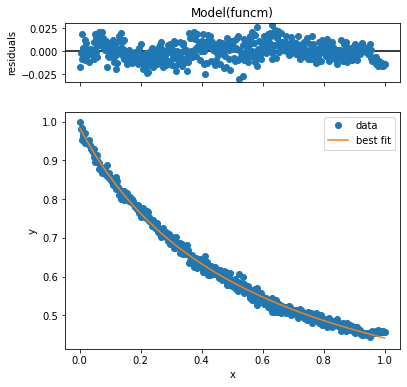

In [62]:
from lmfit import Model

def funcm(x, a, b, c):
    return a/(x+c) + b

def funcg(x, a, b, c, d):
    return (a*x +b)/(c*x+d)

m = Model(funcm)
params = m.make_params(a=1, b=0.5, c=1)
result = m.fit(y_malicious, params, x=x)
print(result.fit_report())

# make a stacked plot of residual and data + fit
result.plot()
plt.show()